# Notebook 2: Model Development
Kaggle link: https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability

In [1]:
import os, re, gc

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')
os.chdir("/content/gdrive/My Drive/Credit Risk Model/code")

Mounted at /content/gdrive/


In [3]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
import joblib

In [5]:
# import tensorflow as tf
import keras
from keras import Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, LeakyReLU
from keras.regularizers import L1, L2
from keras.activations import relu, softplus, sigmoid
from keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [6]:
from xgboost import XGBClassifier, cv, DMatrix

In [7]:
from utils import *

## Configuration

In [8]:
path = os.getcwd()
wd = os.path.dirname(path).replace("\\", "/")
data_path = wd + "/data"
model_path = wd + "/model"

In [9]:
seed = 101
np.random.seed(seed)

## Data Preparation

In [10]:
target = read_file(data_path + "/cleaned/dev_base.csv")
features = read_file(data_path + "/cleaned/dev_feat.csv")

### Train-test Split
Use `WEEK_NUM` to split the test set from the data so as to assess model stability in the future.

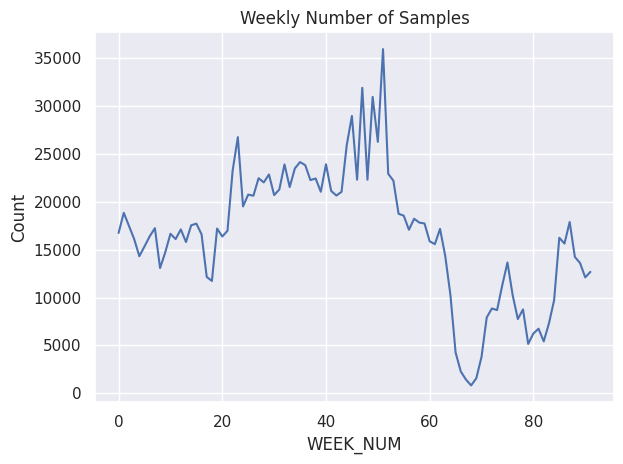

In [11]:
week_num = target["WEEK_NUM"].value_counts().sort("WEEK_NUM")
sns.set_theme()
plt.plot(week_num["count"]);
plt.xlabel("WEEK_NUM")
plt.ylabel("Count")
plt.title("Weekly Number of Samples")
plt.tight_layout();

In [12]:
train_case = target.filter(pl.col("WEEK_NUM") < 80)["case_id"]
test_case = target.filter(pl.col("WEEK_NUM") >= 80)["case_id"]

In [13]:
X_train = features.filter(pl.col("case_id").is_in(train_case)).drop("case_id").to_numpy()
Y_train = target.filter(pl.col("case_id").is_in(train_case))["target"].to_numpy()

In [14]:
X_test = features.filter(pl.col("case_id").is_in(test_case)).drop("case_id").to_numpy()
Y_test = target.filter(pl.col("case_id").is_in(test_case))["target"].to_numpy()

In [15]:
X_train = np.float32(X_train)
X_test = np.float32(X_test)

In [16]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1388865, 299), (1388865,), (137794, 299), (137794,))

In [17]:
# Save memory
train_base = target.filter(pl.col("case_id").is_in(train_case)).to_pandas()
test_base = target.filter(pl.col("case_id").is_in(test_case)).to_pandas()
del features, target
gc.collect()

3426

### Features Scaling

In [18]:
# Standardize features before training a MLP model.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
joblib.dump(scaler, model_path + "/scaler.sav")

['/content/gdrive/My Drive/Credit Risk Model/model/scaler.sav']

## Model Trainig

### Baseline: Logistic Regression
As we have a large number of features, PCA is applied and the logistic regression is fitted with k pricnipal components who account for 99% of the variance of the dataset.

In [20]:
pca = PCA(random_state=seed)
LR = LogisticRegression(C=2, random_state=seed)

In [21]:
Z_train = pca.fit_transform(X_train)
Z_test = pca.transform(X_test)

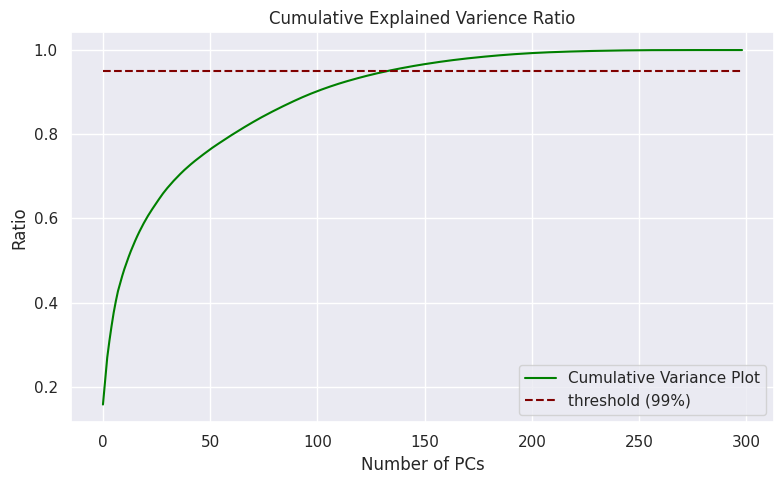

In [22]:
# Cumulative variance plot
cum_var = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(cum_var, color ='green', label="Cumulative Variance Plot")
ax.plot(np.repeat(0.95, len(cum_var)), label="threshold (99%)",
        color='maroon', linestyle='dashed')
ax.set_xlabel('Number of PCs')
ax.set_ylabel('Ratio')
ax.set_title('Cumulative Explained Varience Ratio')
ax.legend()
plt.tight_layout();

In [23]:
k = np.argmax(cum_var > 0.99); k

192

In [24]:
Z_train = Z_train[:,:k]
Z_test = Z_test[:,:k]

In [25]:
LR.fit(Z_train, Y_train)

LogisticRegression(C=2, random_state=101)

In [26]:
joblib.dump(pca, model_path + "/pca.sav")
joblib.dump(LR, model_path + "/lr.sav")

['/content/gdrive/My Drive/Credit Risk Model/model/lr.sav']

### Benchmark: XGBoost

In [27]:
params = {
    'objective':'binary:logistic',
    'max_depth':8,
    'n_estimators':64,
    'learning_rate':.1,
    'seed':seed,
    "scale_pos_weight":(Y_train==0).sum()/(Y_train==1).sum()
    }

In [28]:
XGB = XGBClassifier(**params)

In [29]:
XGB.fit(X_train, Y_train, verbose=True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=64, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [30]:
XGB.save_model(model_path + "/xgb.json")

### Deep Neural Network

A few changes to the traditional MLP classifier we are going to attempt are:
- *Focal Loss Function*: $$FL(p_t) = - \alpha_t(1-p_t)^\gamma\log(p_t)\quad\text{for class $t$}$$
Predicting defaults usually comes with a highly imbalance dataset. As upsamling schemes can be computationally expensive for such a massive dataset, we instead use a focal loss function to put much heavier penalties on False Negative (Type II Error).
- *Leaky ReLU Activation*: $$\text{LeakyReLU}(z) = \max(az, z), \quad a\in(0,1)$$
To avoid dying-ReLU problem in deep neural network, the Leaky ReLU activation function is adopted to introduce a non-zero slope for the negative input value.

Define a general form of model architecture.

In [56]:
def create_DNN(hidden_layer_size, n_feats, LRU_slope=0, alpha_lasso=1e-2, dropout_rate=.1, dropout_seed=None, loss_func=BinaryCrossentropy(), lr=1e-3):
    '''
    Create a DNN model with the given array of hidden_layer_size

    Parameters:
        hidden_layer_size: The ith element represents the number of neurons in the ith hidden layer.
        n_feats: Number of features / Dimension of X.
        LRU_slope: Slope of the LeakyReLu activation function. Set to 0 for normal ReLu.
        alpha_lasso: Strength of L1 regularization.
        dropout_rate: Fraction of the input units to drop during trainig.
        dropout_seed: Random seed for the dropout layer.
        loss_func: Loss function.
        lr: Learning rate of Adam.
        (Note: When alpha_FL=.5 and gamma_FL=0, FL is eqivalent to CE in ordinal sense.)

    Returns:
        A complied Keras model (ready to train).
    '''

    # Regularizer
    lasso = L1(alpha_lasso)

    # Input layer
    x = Input(shape=(n_feats,))
    layer = 0

    # Hidden layer
    for h in hidden_layer_size:
        z = Dropout(rate=dropout_rate, seed=dropout_seed)(x if layer == 0 else z)
        z = Dense(h, kernel_regularizer=lasso)(z)
        z = LeakyReLU(LRU_slope)(z)
        z = BatchNormalization()(z)
        layer += 1

    # Output layer
    p = Dense(1, activation="sigmoid")(z)

    # Create anc compile model
    model = Model(inputs=x, outputs=p)
    model.compile(loss=loss_func, optimizer=Adam(learning_rate=lr))

    return model

Tune the following hyperparameters:
- Model archtectiure (number of hidden layer and unit):
    - Shallow Network: 2048-256-32
    - Deep Network: 512-128-128-32-32
- Slope of Leaky-ReLU activation function on the negative x axis: [0, 0.1, 0.3]
- $\gamma$ of the focal loss function: [0, 1, 2]
    - Note: When $\gamma = 0$, we switch back to binary cross-entropy loss function with upsampling performed. The reason is that we want to have a benchmark for showing the effectiveness of the focal loss function in handling imbalanced label (without upsampling).

In [57]:
# alpha_FL = 1 - sum(Y_train)/len(Y_train)  # 1 - class frequency proportion
alpha_FL = .99
param_grid = {
    "architecture": {"simple":np.array([128, 32]),
                     "shallow":np.array([512, 64, 8]),
                     "deep":np.array([256, 64, 64, 16, 16])},
    "LeakyReLU_negative_slope":[0, 0.01, 0.03],
    "loss_func":[BinaryCrossentropy(),
                 BinaryFocalCrossentropy(alpha=alpha_FL, gamma=1),
                 BinaryFocalCrossentropy(alpha=alpha_FL, gamma=2)]
}

In [58]:
n_model = len(param_grid["architecture"]) * len(param_grid["LeakyReLU_negative_slope"]) * len(param_grid["loss_func"])
skf = StratifiedKFold(n_splits=n_model, shuffle=True, random_state=seed)

In [59]:
n_model

27

In [60]:
hparam_idx = np.array(
    np.meshgrid(np.arange(len(param_grid["architecture"])), np.arange(len(param_grid["LeakyReLU_negative_slope"])), np.arange(len(param_grid["loss_func"])))
    ).T.reshape(n_model,3)

In [61]:
keras.utils.set_random_seed(seed)

In [62]:
arch, slope, gamma, auc_valid, PD_valid_std = [], [], [], [], []

for i, (train_idx, valid_idx) in enumerate(skf.split(X_train, Y_train)):

    Xi_train = X_train[train_idx,:]
    Yi_train = Y_train[train_idx]
    Xi_valid = X_train[valid_idx,:]
    Yi_valid = Y_train[valid_idx]

    # Define the candidate model
    arch.append(list(param_grid["architecture"].keys())[hparam_idx[i,0]])
    slope.append(param_grid["LeakyReLU_negative_slope"][hparam_idx[i,1]])
    loss = param_grid["loss_func"][hparam_idx[i,2]]
    gamma.append(hparam_idx[i,2])

    candidate = create_DNN(
        hidden_layer_size=param_grid["architecture"][arch[i]],
        LRU_slope=slope[i],
        loss_func=loss,
        n_feats=X_train.shape[1],
        dropout_seed=seed
    )

    print("Model {0}: architecture={1}, LeakyReLU_negative_slope={2}, gamma={3}".format(i, arch[i], slope[i], gamma[i]))

    # Train the model
    if gamma[i] == 0:  # upsampling is needed for CE loss in order to avoid garbage output
        ros = RandomOverSampler(random_state=seed)
        Xi_train, Yi_train = ros.fit_resample(Xi_train, Yi_train)

    candidate.fit(
        Xi_train,
        Yi_train,
        epochs=100,
        batch_size=int(Xi_train.shape[0]/100),
        verbose=2,
        validation_data=[Xi_valid, Yi_valid],
        callbacks=EarlyStopping(monitor='loss', patience=2, mode='auto')
    )

    # Evaluate the model
    # p_train = candidate.predict(Xi_train).flatten()
    p_valid = candidate.predict(Xi_valid).flatten()

    # auc_train.append(roc_auc_score(Yi_train, p_train))
    auc_valid.append(roc_auc_score(Yi_valid, p_valid))
    PD_valid_std.append(p_valid.std())

    # Save model
    candidate.save(model_path + "/mlp_{}.keras".format(i))

    # Release RAM
    del candidate
    gc.collect()

    print("*"*80)

Model 0: architecture=simple, LeakyReLU_negative_slope=0, gamma=0
Epoch 1/100
101/101 - 5s - loss: 12.1756 - val_loss: 2.3662 - 5s/epoch - 54ms/step
Epoch 2/100
101/101 - 1s - loss: 1.2954 - val_loss: 0.8939 - 1s/epoch - 14ms/step
Epoch 3/100
101/101 - 2s - loss: 0.7551 - val_loss: 0.8113 - 2s/epoch - 15ms/step
Epoch 4/100
101/101 - 2s - loss: 0.6920 - val_loss: 0.7700 - 2s/epoch - 15ms/step
Epoch 5/100
101/101 - 1s - loss: 0.6937 - val_loss: 0.7486 - 1s/epoch - 14ms/step
Epoch 6/100
101/101 - 1s - loss: 0.6811 - val_loss: 0.6534 - 1s/epoch - 15ms/step
Epoch 7/100
101/101 - 1s - loss: 0.6651 - val_loss: 0.6438 - 1s/epoch - 15ms/step
Epoch 8/100
101/101 - 1s - loss: 0.6637 - val_loss: 0.7499 - 1s/epoch - 15ms/step
Epoch 9/100
101/101 - 1s - loss: 0.7213 - val_loss: 0.7966 - 1s/epoch - 14ms/step
Epoch 10/100
101/101 - 1s - loss: 0.6783 - val_loss: 0.7319 - 1s/epoch - 14ms/step
1608/1608 [==============================] - 2s 1ms/step
*******************************************************

In [ ]:
report = pd.DataFrame({
    "architecture": arch,
    "LeakyReLU_negative_slope": slope,
    "gamma":gamma,
    "AUC_valid":auc_valid,
    "PD_valid_std":PD_valid_std
})

In [ ]:
report

,architecture,LeakyReLU_negative_slope,gamma,AUC_valid,PD_valid_mean,PD_valid_std
0,simple,0.00,0,0.677617,0.452482,2.607090e-01
1,simple,0.01,0,0.741931,0.441644,2.010035e-01
2,simple,0.03,0,0.658881,0.434799,9.161495e-02
3,shallow,0.00,0,0.760146,0.461581,7.651764e-02
4,shallow,0.01,0,0.694366,0.422182,1.992381e-01
5,shallow,0.03,0,0.758382,0.460269,1.125473e-01
6,deep,0.00,0,0.713424,0.497763,1.782817e-01
7,deep,0.01,0,0.689308,0.614054,1.564649e-01
8,deep,0.03,0,0.754749,0.496143,4.857833e-02
9,simple,0.00,1,0.761207,0.097340,3.154609e-02


Some model have extremely low deviations in PD (especially when $\gamma=2$ in a deep network), which should not be considered for further analysis.

In [ ]:
report = report[report["PD_valid_std"] > .0001]

In [ ]:
report.groupby("gamma")["AUC_valid"].mean()

In [ ]:
report.groupby(["architecture", "LeakyReLU_negative_slope"])["AUC_valid"].mean()

In [ ]:
report["AUC_valid"].argmax()

In [38]:
best_model_idx = 24

In [39]:
DNN = keras.models.load_model(model_path + "/mlp_{}.keras".format(best_model_idx))

## Model Evaluation

In [31]:
def stability_plot(result, ax, label=None):
    '''
    Plot the weekly AUC against time in week
    '''

    auc_weekly = result.groupby("WEEK_NUM").apply(lambda df: roc_auc_score(df["target"], df["model_PD"]))
    if label != None:
        ax.plot(auc_weekly, label=label)
    else:
        ax.plot(auc_weekly)
    ax.set_xlabel("WEEK_NUM")
    ax.set_ylabel("AUC")
    ax.set_ylim(.5,1)
    ax.set_title("Analysis of Model Stability by Weekly AUC")

    return ax

def stability_metric(result):
    '''
    Evaluate the model with a gini stability metric
    '''

    auc_weekly = result.groupby("WEEK_NUM").apply(lambda df: roc_auc_score(df["target"], df["model_PD"]))
    gini = 2 * auc_weekly - 1
    t = np.arange(len(gini))
    a, b = np.polyfit(t, gini, 1)  # linear regression
    residuals = gini - (a * t + b)
    std_res = np.std(residuals)
    stability = np.mean(gini) + 88 * np.min([0,a]) - .5 * std_res

    return stability

In [32]:
# p_train_LR = LR.predict_proba(Z_train)[:,1]
p_test_LR = LR.predict_proba(Z_test)[:,1]

In [33]:
# p_train_XGB = XGB.predict_proba(X_train)[:,1]
p_test_XGB = XGB.predict_proba(X_test)[:,1]

In [40]:
# p_train_DNN = DNN.predict(X_train).flatten()
p_test_DNN = DNN.predict(X_test).flatten()

4307/4307 [==============================] - 8s 2ms/step


### Comparing Model ROCs

In [41]:
fpr_LR, tpr_LR, thresholds_LR = roc_curve(Y_test, p_test_LR)
auc_LR = auc(fpr_LR, tpr_LR)

In [42]:
fpr_XGB, tpr_XGB, thresholds_XGB = roc_curve(Y_test, p_test_XGB)
auc_XGB = auc(fpr_XGB, tpr_XGB)

In [43]:
fpr_DNN, tpr_DNN, thresholds_DNN = roc_curve(Y_test, p_test_DNN)
auc_DNN = auc(fpr_DNN, tpr_DNN)

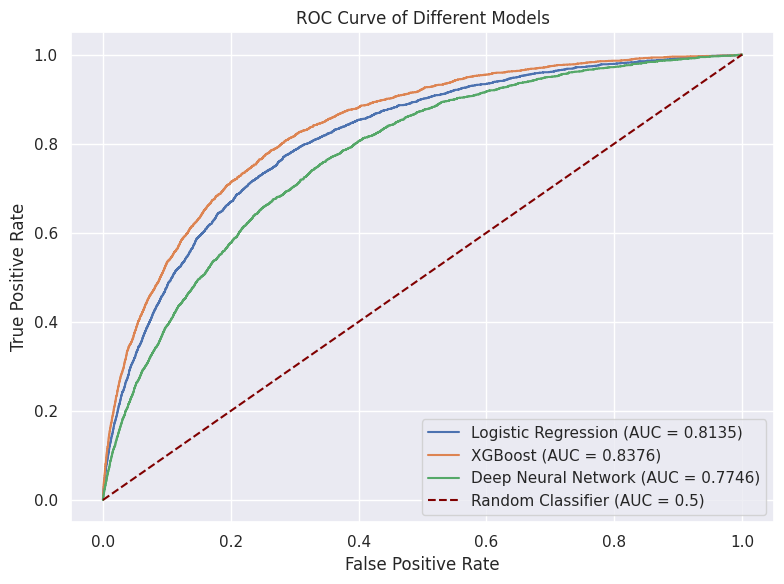

In [51]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(fpr_LR, tpr_LR, label="Logistic Regression (AUC = {})".format(auc_LR.round(4)))
ax.plot(fpr_XGB, tpr_XGB, label="XGBoost (AUC = {})".format(auc_XGB.round(4)))
ax.plot(fpr_DNN, tpr_DNN, label="Deep Neural Network (AUC = {})".format(auc_DNN.round(4)))
ax.plot(np.linspace(0,1,1000), np.linspace(0,1,1000), label="Random Classifier (AUC = 0.5)",
        color='maroon', linestyle='dashed')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve of Different Models")
ax.legend()
plt.tight_layout();

### Model Stability

In [47]:
LR_result = pd.concat([test_base, pd.DataFrame({"model_PD":p_test_LR})], axis=1)
XGB_result = pd.concat([test_base, pd.DataFrame({"model_PD":p_test_XGB})], axis=1)
DNN_result = pd.concat([test_base, pd.DataFrame({"model_PD":p_test_DNN})], axis=1)

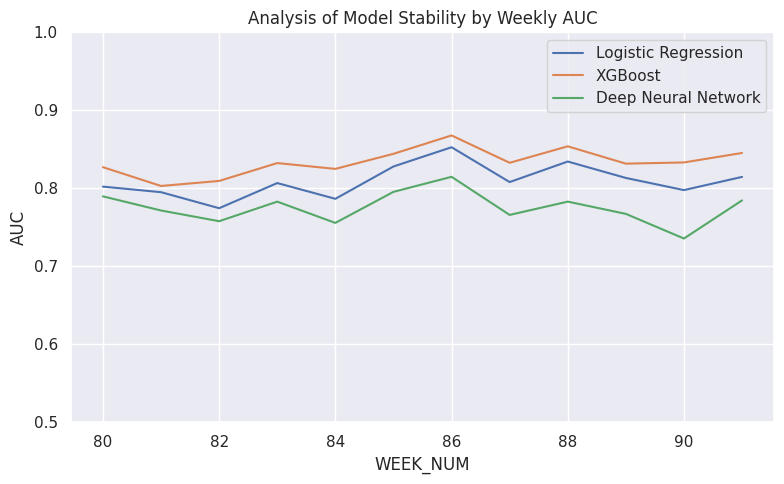

In [52]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(8,5))
stability_plot(LR_result, ax=ax, label="Logistic Regression")
stability_plot(XGB_result, ax=ax, label="XGBoost")
stability_plot(DNN_result, ax=ax, label="Deep Neural Network")
ax.legend()
plt.tight_layout();

In [55]:
pd.DataFrame({
    "Logistic Regression":[stability_metric(LR_result)],
    "XGBoost":[stability_metric(XGB_result)],
    "Deep Neural Network":[stability_metric(DNN_result)],
    }, index=["stability metric"])

,Logistic Regression,XGBoost,Deep Neural Network
stability metric,0.600037,0.653407,0.368389


- Result on PCA + Logistic Regression is surprisingly good. Should we try Autoencoder?
    - Idea 1: Use Autoencoder to replace PCA.
        - PCA + Logistic Regression actually does not make sense when we applied ordinal encoding on categorical features as the model is linear.
    - Idea 2: Apply One-hot encoding on categorical features, then comprass the dimensionality by autoencoder.

## Hybrid Model